In [38]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.cross_validation import train_test_split
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve
from sklearn import metrics

%matplotlib inline

In [39]:
train = pd.read_csv('../input/train.csv')
test = pd.read_csv('../input/valid.csv')

In [40]:
# assigning X,y
y_train = train['TARGET']
X_train = pd.get_dummies(train.drop(['TARGET','SK_ID_CURR'], axis=1), dummy_na=True)

In [41]:
gboost_optimized = GradientBoostingClassifier(n_estimators=500,
                                             learning_rate=0.1,
                                             min_samples_split=15000,
                                             min_samples_leaf=1000,
                                             max_depth=5,
                                             subsample=1.0,
                                             max_features=150)

In [42]:
gboost_optimized.fit(X_train.fillna(value=0), y_train)

GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=5,
              max_features=150, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1000, min_samples_split=15000,
              min_weight_fraction_leaf=0.0, n_estimators=500,
              presort='auto', random_state=None, subsample=1.0, verbose=0,
              warm_start=False)

In [43]:
set(X_train.columns) - set(X_test.columns)

{'CNT_ACTIVE_LOANS',
 'CNT_BAD_DEBT',
 'CNT_CC_DRAWINGS',
 'CNT_CLOSED_DEBT',
 'CNT_LOANS_APPROVED',
 'CNT_LOANS_CANCELLED',
 'CNT_LOANS_REFUSED',
 'CNT_SOLD_DEBT',
 'CNT_UNUSED_OFFERS',
 'SK_ID_CURR.1',
 'SK_ID_CURR.2',
 'SK_ID_CURR.3'}

In [44]:
y_test = test['TARGET']
X_test = pd.get_dummies(test.drop(['TARGET','SK_ID_CURR'], axis=1), dummy_na=True)
#X_test.loc[:,'CODE_GENDER_XNA'] = 0
#X_test.loc[:,'NAME_FAMILY_STATUS_Unknown'] = 0

predictions = gboost_optimized.predict(X_test.fillna(0))
pred_prob = gboost_optimized.predict_proba(X_test.fillna(0))

In [58]:
print(classification_report(y_test, predictions))

print(confusion_matrix(y_test, predictions))
print('\n')
print(roc_auc_score(y_test, pred_prob[:,1]))

             precision    recall  f1-score   support

        0.0       0.92      1.00      0.96     56510
        1.0       0.54      0.02      0.04      4991

avg / total       0.89      0.92      0.88     61501

[[56422    88]
 [ 4887   104]]


0.7614601132507458


In [48]:
fpr, tpr, thresholds = roc_curve(y_test, pred_prob[:,1])

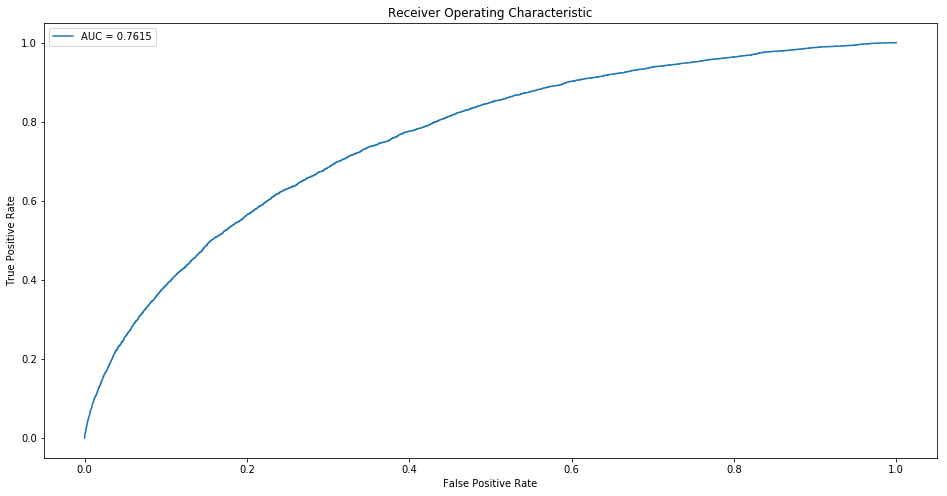

In [49]:
plt.figure(figsize=(16,8))
plt.title('Receiver Operating Characteristic')
plt.plot(fpr,tpr, label='AUC = %0.4f'% roc_auc_score(y_test, pred_prob[:,1]))
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend(loc='upper left')

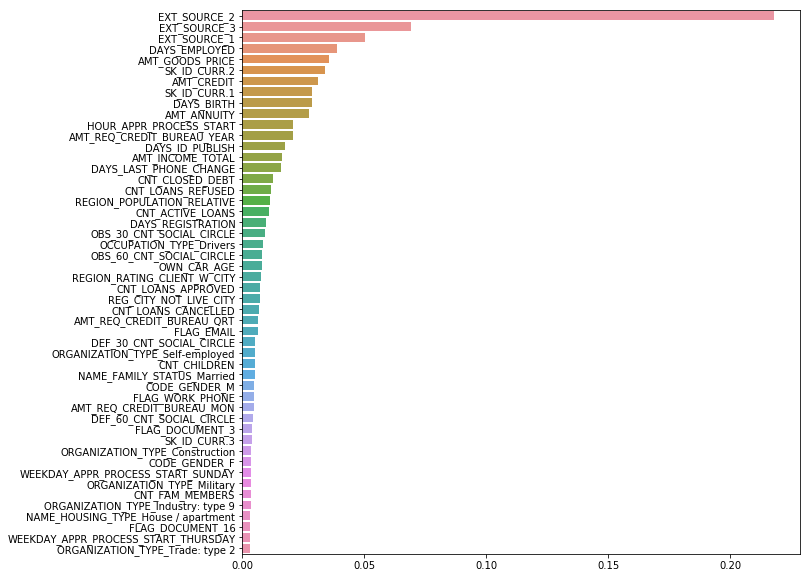

In [50]:
summary = pd.Series(gboost_optimized.feature_importances_)
summary.index = X_test.columns
summary.sort_values(ascending=False, inplace=True)

plt.figure(figsize=(10,10))
sns.barplot(y=summary[:50].index.values, x=summary[:50].values)

In [51]:
infer_csv = pd.read_csv('../input/infer.csv')

In [52]:
X = infer_csv
X = pd.get_dummies(X.drop(['SK_ID_CURR'], axis=1), dummy_na=True)
infer_csv.set_index('SK_ID_CURR', inplace=True)

#X.loc[:,'CODE_GENDER_XNA'] = 0
#X.loc[:,'NAME_FAMILY_STATUS_Unknown'] = 0

In [53]:
probs = gboost_optimized.predict_proba(X.fillna(0))

In [54]:
submission = pd.DataFrame()
submission['TARGET'] = probs[:,1]
submission.index = infer_csv.index

In [55]:
submission.to_csv('gboost-optimized-rev-3.csv')